<a href="https://colab.research.google.com/github/MicheleGiambelli/Deep-Learning-Project/blob/Michele/MyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Dataset path
dataset_path = '/content/drive/MyDrive/food_12_small' #Mettete la vostra PATH al dataset

In [3]:
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm

In [4]:
def get_dataloader_workers():
    """Use as many processes working in parallel to read the data as # CPU cores.
    Other recommended range: 2 to 4"""
    import os
    return os.cpu_count()

def data_loader(dataset_path, batch_size, height, width, train_perc = 0.7, val_perc = 0.2, seed = 123):

    np.random.seed(seed)
    torch.manual_seed(seed)

    trans = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize a 224x224
      transforms.Grayscale(),
      transforms.ToTensor()          # Converti in tensore
    ])

    # Upload dataset with ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=trans)

    # Compute splitting size
    dataset_size = len(dataset)
    train_size = int(train_perc * dataset_size)
    val_size = int(val_perc * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Creazione dei DataLoader
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=get_dataloader_workers())
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=get_dataloader_workers())
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=get_dataloader_workers())


    return dataset, train_loader, val_loader, test_loader


In [5]:
dataset, train_loader, val_loader, test_loader = data_loader(dataset_path,
                                                             batch_size=32,
                                                             height=224, width=224)

In [6]:
class_to_idx = dataset.class_to_idx
class_to_idx

{'beef_tartare': 0,
 'bruschetta': 1,
 'caesar_salad': 2,
 'cannoli': 3,
 'chicken_wings': 4,
 'chocolate_cake': 5,
 'club_sandwich': 6,
 'dumplings': 7,
 'hot_dog': 8,
 'ice_cream': 9,
 'pizza': 10,
 'ramen': 11}

# CNN

In [7]:
class MyCNN(nn.Module):

    def __init__(self, input_channels: int,
                 hidden_layers: list,
                 use_batch_normalization: bool,
                 n_output: int,
                 kernel_size: list,
                 activation_function: torch.nn.Module = torch.nn.ReLU()):

        super().__init__()

        self.hidden_layers = hidden_layers
        self.use_batch_normalization = use_batch_normalization
        self.activation_function = activation_function

        #Build the CNN
        self.conv_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList() if use_batch_normalization else None
        self.dropout = nn.Dropout(p=0.5)

        for i in range(len(hidden_layers)):
            # Add a CNN layer
            layer = nn.Conv2d(in_channels = input_channels,
                              out_channels = hidden_layers[i],
                              kernel_size = kernel_size[i],
                              stride=1,
                              padding = kernel_size[i]//2,
                              padding_mode="zeros",
                              bias = not use_batch_normalization
                              )
            self.conv_layers.append(layer)

            if use_batch_normalization:
                self.batch_norm_layers.append(nn.BatchNorm2d(hidden_layers[i]))

            input_channels = hidden_layers[i]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.output_layer = nn.Linear(hidden_layers[-1] * (224 // (2**len(hidden_layers)))**2, n_output)



    def forward(self, input_images: torch.Tensor) -> torch.Tensor:

        for i in range(len(self.hidden_layers)):
            input_images = self.conv_layers[i](input_images)
            if self.use_batch_normalization:
                 input_images = self.batch_norm_layers[i](input_images)
            input_images = self.activation_function(input_images)
            input_images = self.pool(input_images)
            input_images = self.dropout(input_images)

        input_images = input_images.view(input_images.size(0), -1) #Flatten the tensor
        prediction = self.output_layer(input_images)

        return prediction

In [8]:
model = MyCNN(input_channels = 1,
                  hidden_layers = [32, 64, 128, 256],
                  use_batch_normalization = "True",
                  n_output = 12,
                  kernel_size = [3, 5, 7, 9])

## Training Loop

In [11]:
def accuracy(predictions, targets):
    correct = 0
    total = 0
    _, pred_labels = torch.max(predictions, 1)
    total = targets.size(0)
    correct = (pred_labels == targets).sum().item()

    accuracy = correct / total
    return accuracy

def training_loop(network,
                  training_loader,
                  validation_loader,
                  num_epochs,
                  device = "cuda",
                  learning_rate = 1e-3,
                  show_progress: bool = False,
                  patience = 3,
                  ):

    device = torch.device(device if torch.cuda.is_available() else 'cpu')

    # Move the network to the device
    network.to(device)

    # Create an optimizer Adam
    optimizer = torch.optim.Adam(network.parameters(), lr = learning_rate)
    #Create loss function Cross Entropy
    loss_function = torch.nn.CrossEntropyLoss()

    # Lists to store the training and evaluation losses/accuracy
    train_losses = []
    eval_losses = []
    train_acc = []
    eval_acc = []
    best_eval_loss = float('inf')
    best_eval_acc = 0.0
    best_epoch = 0

    # Perform num_epoch full iterations over train_data
    for epoch in range(num_epochs):
        # Training phase
        network.train()
        epoch_train_loss = []
        epoch_train_acc = []

        for input_img, target  in tqdm(training_loader, desc = f"Epoch {epoch+1}/{num_epochs}", disable = not show_progress):
            input_img = input_img.to(device)
            target = target.to(device)
            # Reset the gradient
            optimizer.zero_grad()
            # Compute the output
            output = network(input_img)
            # Compute the loss with Cross-Entropy for the current batch
            loss = loss_function(output, target)
            # Compute the gradient
            loss.backward()
            # Perform the update
            optimizer.step()

            # Collect minibatch training loss to compute the average loss of the epoch
            epoch_train_loss.append(loss.item())
            #Compute training accuracy
            acc = accuracy(output, target)
            epoch_train_acc.append(acc)


        # Average loss for the current epoch
        average_loss_train = torch.mean(torch.tensor(epoch_train_loss))
        train_losses.append(average_loss_train)
        #Average accuracy for the current epoch
        average_train_accuracy = torch.mean(torch.tensor(epoch_train_acc))
        train_acc.append(average_train_accuracy)

        # After an epoch of training --> full iteration over evaluation data
        network.eval() # setting network in evaluation mode
        epoch_eval_loss = []
        epoch_eval_acc = []

        with torch.no_grad(): # Set no update for the weights
            for input_img, target in tqdm(validation_loader, desc = f"Epoch {epoch+1}/{num_epochs}", disable = not show_progress):
                input_img = input_img.to(device)
                target = target.to(device)
                output = network(input_img)
                loss = loss_function(output, target)
                epoch_eval_loss.append(loss.item())
                acc = accuracy(output, target)
                epoch_eval_acc.append(acc)

        average_loss_eval = torch.mean(torch.tensor(epoch_eval_loss))
        eval_losses.append(average_loss_eval)
        average_eval_accuracy = torch.mean(torch.tensor(epoch_eval_acc))
        eval_acc.append(average_eval_accuracy)


        if show_progress:
            print(f"EPOCH: {epoch+1} --- Train loss: {average_loss_train:7.4f} --- Eval loss: {average_loss_eval:7.4f}\n")
            print(f"Train accuracy: {average_train_accuracy:7.4f} --- Eval accuracy: {average_eval_accuracy:7.4f}\n")

        # Early stopping
        if average_loss_eval < best_eval_loss:
            best_eval_loss = average_loss_eval
            best_eval_acc = average_eval_accuracy
            best_epoch = epoch
            patience_counter = 0
            torch.save(network.state_dict(), "model.pth") #Save the best model till the current epoch
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs\n")
            # Load the best model at the end of training
            network.load_state_dict(torch.load("model.pth"))
            print(f"BEST MODEL at EPOCH: {best_epoch+1} --- Eval loss: {best_eval_loss:7.4f} --- Eval accuracy: {best_eval_acc:7.4f}")
            break

    print("--- Training Ended! ---")
    return train_losses, eval_losses, train_acc, eval_acc, best_epoch

In [12]:
train_losses, val_losses, train_acc, val_acc, best_epoch = training_loop(model,
                                                                         train_loader,
                                                                         val_loader,
                                                                         num_epochs=50,
                                                                         learning_rate=0.001,
                                                                         show_progress=True)

Epoch 1/50: 100%|██████████| 15/15 [01:12<00:00,  4.81s/it]


EPOCH: 1 --- Train loss: 13.4044 --- Eval loss:  6.6912

Train accuracy:  0.1032 --- Eval accuracy:  0.1167



Epoch 2/50: 100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


EPOCH: 2 --- Train loss:  5.9534 --- Eval loss:  5.2726

Train accuracy:  0.1279 --- Eval accuracy:  0.1167



Epoch 3/50: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


EPOCH: 3 --- Train loss:  4.9583 --- Eval loss:  4.6928

Train accuracy:  0.1639 --- Eval accuracy:  0.1542



Epoch 4/50: 100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


EPOCH: 4 --- Train loss:  4.7116 --- Eval loss:  4.8540

Train accuracy:  0.1893 --- Eval accuracy:  0.1312



Epoch 5/50: 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


EPOCH: 5 --- Train loss:  4.4681 --- Eval loss:  4.7228

Train accuracy:  0.1846 --- Eval accuracy:  0.1604



Epoch 6/50: 100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


EPOCH: 6 --- Train loss:  3.9494 --- Eval loss:  3.7079

Train accuracy:  0.2164 --- Eval accuracy:  0.1625



Epoch 7/50: 100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


EPOCH: 7 --- Train loss:  3.0446 --- Eval loss:  3.4896

Train accuracy:  0.2647 --- Eval accuracy:  0.1937



Epoch 8/50: 100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


EPOCH: 8 --- Train loss:  2.7507 --- Eval loss:  3.1353

Train accuracy:  0.2842 --- Eval accuracy:  0.2104



Epoch 9/50: 100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


EPOCH: 9 --- Train loss:  2.4028 --- Eval loss:  3.0522

Train accuracy:  0.3361 --- Eval accuracy:  0.2167



Epoch 10/50: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]


EPOCH: 10 --- Train loss:  2.2310 --- Eval loss:  2.9592

Train accuracy:  0.3650 --- Eval accuracy:  0.2354



Epoch 11/50: 100%|██████████| 15/15 [00:02<00:00,  5.40it/s]


EPOCH: 11 --- Train loss:  2.2633 --- Eval loss:  2.9323

Train accuracy:  0.3703 --- Eval accuracy:  0.2521



Epoch 12/50: 100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


EPOCH: 12 --- Train loss:  2.0008 --- Eval loss:  3.0414

Train accuracy:  0.4151 --- Eval accuracy:  0.1958



Epoch 13/50: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


EPOCH: 13 --- Train loss:  1.7062 --- Eval loss:  3.0896

Train accuracy:  0.4629 --- Eval accuracy:  0.2188



Epoch 14/50: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

EPOCH: 14 --- Train loss:  1.6298 --- Eval loss:  3.4460

Train accuracy:  0.4894 --- Eval accuracy:  0.1979

Early stopping triggered after 14 epochs

BEST MODEL at EPOCH: 11 --- Eval loss:  2.9323 --- Eval accuracy:  0.2521
--- Training Ended! ---



<ipython-input-11-192fd8000b28>:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load("model.pth"))


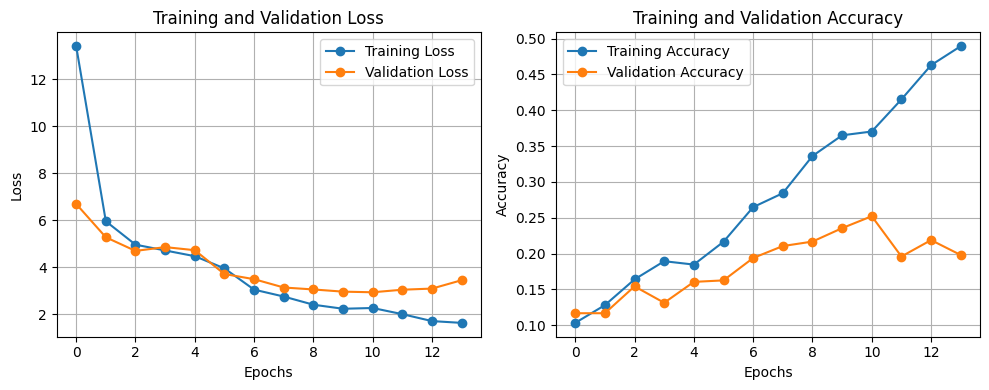

In [17]:
def plot_training_metrics(train_losses, val_losses, train_acc, val_acc):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot Training and Validation Loss on the first subplot
    axes[0].plot(train_losses, label='Training Loss', marker='o')
    axes[0].plot(val_losses, label='Validation Loss', marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Training and Validation Accuracy on the second subplot
    axes[1].plot(train_acc, label='Training Accuracy', marker='o')
    axes[1].plot(val_acc, label='Validation Accuracy', marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

plot_training_metrics(train_losses, val_losses, train_acc, val_acc)

## Test

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device))

<ipython-input-15-8f91c376111c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=device))


<All keys matched successfully>

Accuracy: 23.33%

Report
                 precision    recall  f1-score   support

  beef_tartare       0.16      0.43      0.24        21
    bruschetta       0.14      0.08      0.11        12
  caesar_salad       0.33      0.06      0.10        18
       cannoli       0.00      0.00      0.00        18
 chicken_wings       0.50      0.04      0.07        26
chocolate_cake       0.43      0.46      0.44        26
 club_sandwich       0.33      0.29      0.31        17
     dumplings       0.32      0.59      0.42        17
       hot_dog       0.20      0.12      0.15        25
     ice_cream       0.27      0.12      0.16        26
         pizza       0.12      0.38      0.18        13
         ramen       0.30      0.29      0.29        21

      accuracy                           0.23       240
     macro avg       0.26      0.24      0.21       240
  weighted avg       0.28      0.23      0.21       240



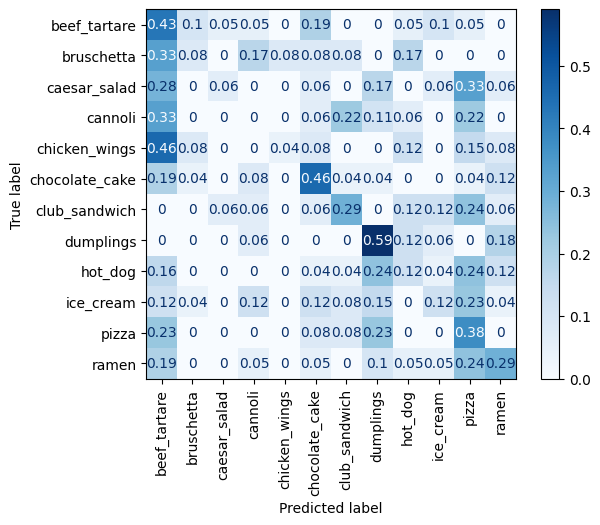

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    Y_true = []
    Y_pred = []
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        Y_pred.extend(torch.argmax(pred, dim=1).cpu().numpy())
        Y_true.extend(y.cpu().numpy())
    acc = accuracy_score(Y_true, Y_pred)
    report = classification_report(Y_true, Y_pred, target_names=class_to_idx.keys())
    conf_mat = confusion_matrix(Y_true, Y_pred, normalize='true')
    conf_mat = np.round(conf_mat, 2)

    return acc, report, conf_mat


acc, report, conf_mat = evaluate_model(model, test_loader, device)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=class_to_idx.keys())
print(f"Accuracy: {round(acc*100, 2)}%\n")
print(f"Report\n {report}")
disp.plot(cmap="Blues", xticks_rotation=90)